<a href="https://colab.research.google.com/github/jawahirkhaleel/Jawahir/blob/main/xee_dust_risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install --upgrade xee

In [9]:
!pip install -U geemap

In [10]:
import ee


In [11]:
ee.Authenticate()
ee.Initialize(
    project = 'ee-jawahirkhaleel05',
    opt_url = 'https://earthengine-highvolume.googleapis.com'
)


In [12]:
import geemap

In [13]:
map = geemap.Map()
map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright', transp…

In [16]:
roi = map.draw_last_feature.geometry()
roi

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "Feature.geometry",
    "arguments": {
      "feature": {
        "functionInvocationValue": {
          "functionName": "Feature",
          "arguments": {
            "geometry": {
              "functionInvocationValue": {
                "functionName": "GeometryConstructors.Polygon",
                "arguments": {
                  "coordinates": {
                    "constantValue": [
                      [
                        [
                          60.117188,
                          22.917923
                        ],
                        [
                          60.117188,
                          37.996163
                        ],
                        [
                          79.804688,
                          37.996163
                        ],
                        [
                          79.804688,
                          22.917923
                        ],
                        [
                          60.117188,
                          22.917923
                        ]
                      ]
                    ]
                  },
                  "geodesic": {
                    "constantValue": false
                  }
                }
              }
            }
          }
        }
      }
    }
  }
})

In [17]:
time_start = ee.Date('2020')
time_end = ee.Date('2021')
time_dif = time_end.difference(time_start, 'month').round()
time_list = ee.List.sequence(0, ee.Number(time_dif).subtract(1)).map(
    lambda x: time_start.advance(x, 'month')
)

In [18]:
aod = (
    ee.ImageCollection("MODIS/061/MCD19A2_GRANULES")
    .filterDate(time_start, time_end)
    .select(['Optical_Depth_055'],['aod'])
    .filter(ee.Filter.eq('SATELLITE','T'))
    .filterBounds(roi)

)

In [19]:
def monthly(date,col):
  start_date = ee.Date(date)
  end_date = start_date.advance(1, 'month')
  col_img = col.filterDate(start_date, end_date).mean()
  col_size = ee.Number(col_img.bandNames().size())
  return col_img.set('system:time_start', start_date.millis()).set('band_size', col_size)

In [20]:
aod_monthly = ee.ImageCollection(
    time_list.map(
        lambda x:monthly(x,aod)
    )
)


In [21]:
terra = (
    ee.ImageCollection("IDAHO_EPSCOR/TERRACLIMATE")
    .filterDate(time_start, time_end)
    .select('pr','soil','vs', 'tmmn', 'tmmx')
)

In [22]:
terra_monthly = ee.ImageCollection(
    time_list.map(
        lambda x: monthly(x, terra)
    )
)


In [23]:
ndvi = (
    ee.ImageCollection("MODIS/061/MOD13Q1")
    .filterDate(time_start, time_end)
    .select(['NDVI'],['ndvi'])
)

In [24]:
ndvi_monthly = ee.ImageCollection(
    time_list.map(
        lambda x: monthly(x, ndvi)
    )
)

In [25]:
collection = aod_monthly.combine(terra_monthly).combine(ndvi_monthly)

mask = (
    ee.ImageCollection("MODIS/061/MCD12Q1")
    .filterDate(time_start, time_end)
    .select('LC_Type1')
    .mode().eq(17).Not().rename('water_mask')
)


In [26]:
import xarray as xr

ds_mask = xr.open_dataset(
    mask,
    engine = 'ee',
    crs = 'EPSG:4326',
    geometry = roi,
    scale = 0.1
)

In [27]:
ds_mask = ds_mask.squeeze('time').drop_vars('time') * 1

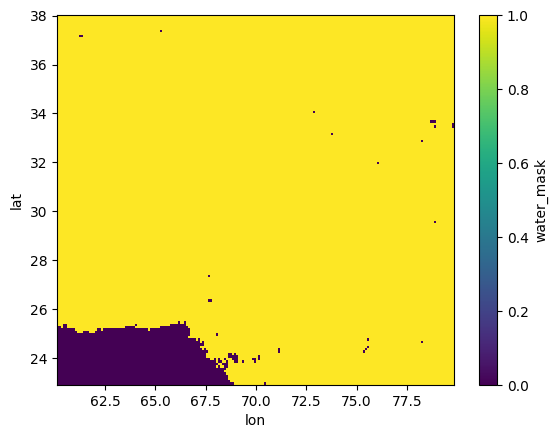

In [28]:
ds_mask.water_mask.plot(
    x = 'lon',
    y = 'lat'
)

In [29]:
ds = xr.open_dataset(
    collection,
    engine ='ee',
    crs = 'EPSG:4326',
    geometry = roi,
    scale = 0.1
)

In [30]:
ds = ds.sortby('time') * 1

In [31]:
import numpy as np

In [32]:
ds = xr.where(ds_mask.water_mask == 0, np.nan, ds)


In [33]:
ds['dust'] = ((ds.aod * 0.001) >= 0.5).astype(int)

In [34]:
ds

<xarray.Dataset> Size: 13MB
Dimensions:  (lon: 197, lat: 151, time: 12)
Coordinates:
  * lon      (lon) float64 2kB 60.17 60.27 60.37 60.47 ... 79.57 79.67 79.77
  * lat      (lat) float64 1kB 22.97 23.07 23.17 23.27 ... 37.77 37.87 37.97
  * time     (time) datetime64[ns] 96B 2020-01-01 2020-02-01 ... 2020-12-01
Data variables:
    aod      (lon, lat, time) float32 1MB nan nan nan nan ... 530.1 181.2 320.0
    pr       (lon, lat, time) float32 1MB nan nan nan nan ... 0.0 0.0 0.0 0.0
    soil     (lon, lat, time) float32 1MB nan nan nan nan ... 0.0 0.0 0.0 0.0
    vs       (lon, lat, time) float32 1MB nan nan nan nan ... 140.0 90.0 60.0
    tmmn     (lon, lat, time) float32 1MB nan nan nan nan ... 56.0 -35.0 -104.0
    tmmx     (lon, lat, time) float32 1MB nan nan nan nan ... 206.0 98.0 4.0
    ndvi     (lon, lat, time) float32 1MB nan nan nan nan ... 451.0 392.0 374.5
    dust     (lon, lat, time) int64 3MB 0 0 0 0 0 0 0 0 0 ... 1 1 1 0 1 1 1 0 0

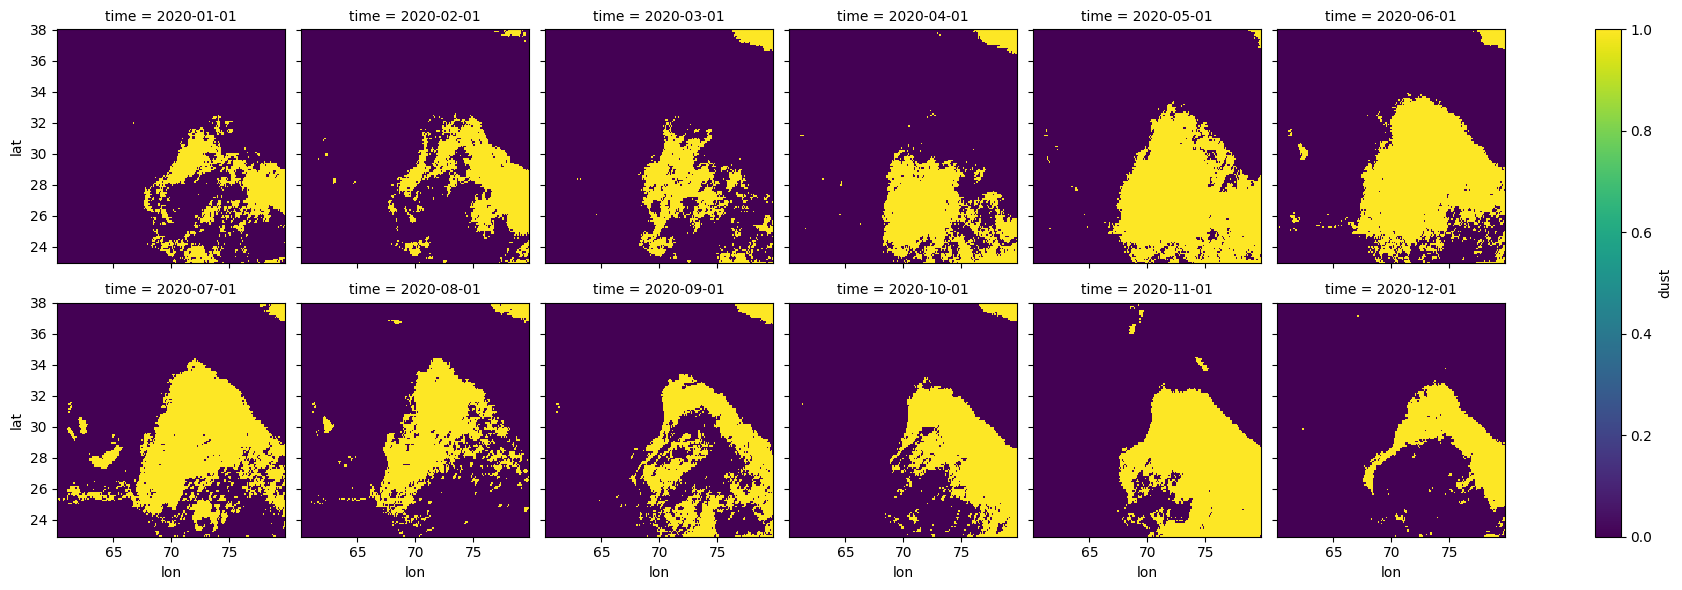

In [35]:
ds.dust.plot(
    x  = 'lon',
    y = 'lat',
    col = 'time',
    col_wrap = 6
)

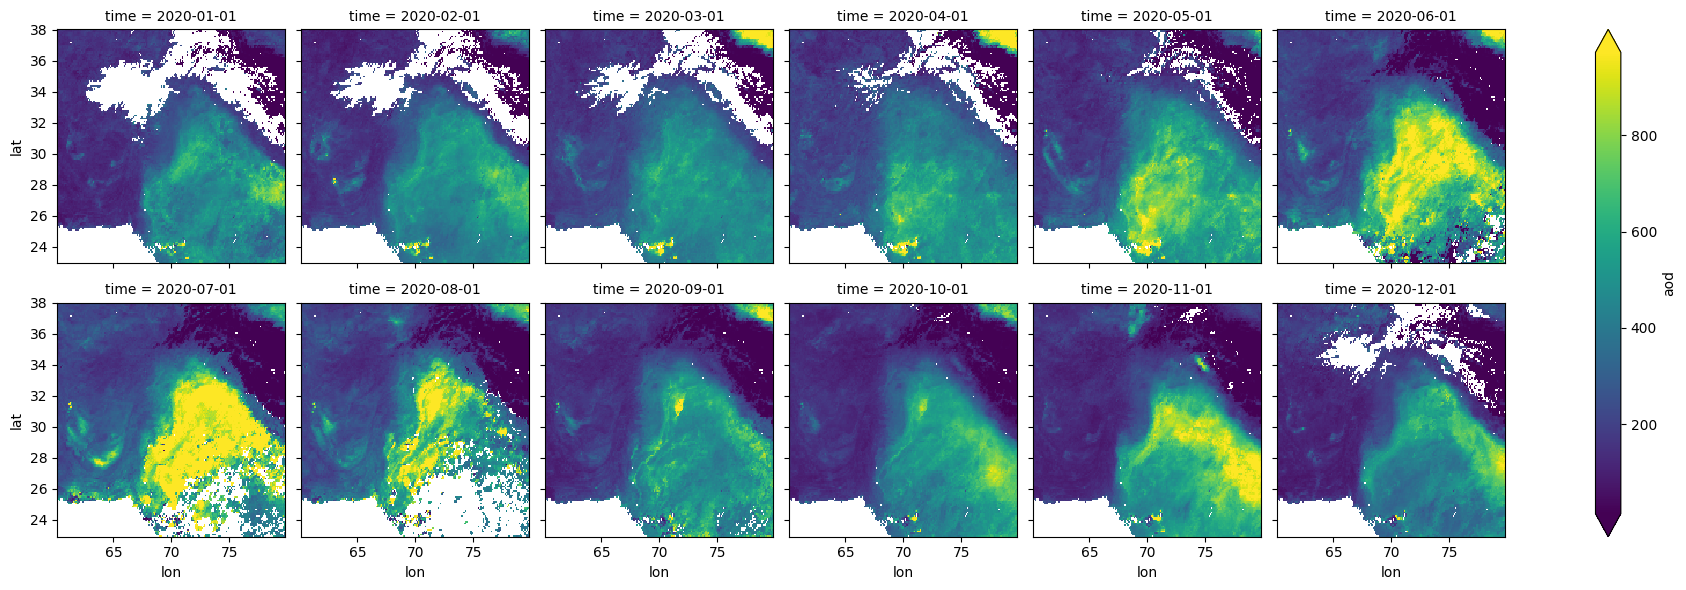

In [36]:
ds.aod.plot(
    x = 'lon',
    y = 'lat',
    col = 'time',
    robust = True,
    col_wrap = 6
)


In [37]:
df = ds.to_dataframe().dropna()
df


aod    pr  soil     vs   tmmn   tmmx  \
lon       lat       time                                                      
60.167188 25.367923 2020-01-01  185.565216  79.0   1.0  343.0  162.0  239.0   
                    2020-02-01  223.352936   1.0   1.0  293.0  189.0  260.0   
                    2020-03-01  194.210526  62.0   1.0  350.0  201.0  270.0   
                    2020-04-01  174.750000   1.0   1.0  343.0  243.0  317.0   
                    2020-05-01  104.375000   0.0   1.0  377.0  290.0  353.0   
...                                    ...   ...   ...    ...    ...    ...   
79.767188 37.967923 2020-08-01  639.615356   1.0   0.0  165.0  217.0  350.0   
                    2020-09-01  531.370361   0.0   0.0  130.0  156.0  297.0   
                    2020-10-01  530.076904   0.0   0.0  140.0   56.0  206.0   
                    2020-11-01  181.181824   0.0   0.0   90.0  -35.0   98.0   
                    2020-12-01  320.049988   0.0   0.0   60.0 -104.0    4.0   

                                 ndvi  dust  
lon       lat       time                     
60.167188 25.367923 2020-01-01  657.0     0  
                    2020-02-01  751.0     0  
                    2020-03-01  758.5     0  
                    2020-04-01  736.0     0  
                    2020-05-01  698.0     0  
...                               ...   ...  
79.767188 37.967923 2020-08-01  465.5     1  
                    2020-09-01  458.5     1  
                    2020-10-01  451.0     1  
                    2020-11-01  392.0     0  
                    2020-12-01  374.5     0  

[311611 rows x 8 columns]

In [38]:
from sklearn.model_selection import train_test_split

In [39]:
x = df[['ndvi','pr','soil','vs', 'tmmn', 'tmmx']]
y = df['dust']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [40]:
from sklearn.linear_model import LogisticRegression


In [41]:
model = LogisticRegression(max_iter = 1000)
model.fit(x_train, y_train)

LogisticRegression(max_iter=1000)

In [42]:
y_pred = model.predict(x_test)
y_prob = model.predict_proba(x_test)

In [43]:
from sklearn.metrics import classification_report, roc_auc_score


In [45]:
class_rep = classification_report(y_test, y_pred)
print(class_rep)


              precision    recall  f1-score   support

           0       0.86      0.91      0.88     48100
           1       0.62      0.49      0.54     14223

    accuracy                           0.81     62323
   macro avg       0.74      0.70      0.71     62323
weighted avg       0.80      0.81      0.81     62323



In [44]:
roc = roc_auc_score(y_test, y_prob[:,1])
print(roc)

0.8777878865349864


In [46]:
df['risk']  = model.predict_proba(df[['ndvi','pr','soil','vs', 'tmmn', 'tmmx']])[:,1]


In [47]:
dfx = df.to_xarray().sortby(['time','lat','lon'])
dfx

<xarray.Dataset> Size: 16MB
Dimensions:  (lon: 197, lat: 151, time: 12)
Coordinates:
  * lon      (lon) float64 2kB 60.17 60.27 60.37 60.47 ... 79.57 79.67 79.77
  * lat      (lat) float64 1kB 22.97 23.07 23.17 23.27 ... 37.77 37.87 37.97
  * time     (time) datetime64[ns] 96B 2020-01-01 2020-02-01 ... 2020-12-01
Data variables:
    aod      (lon, lat, time) float32 1MB nan nan nan nan ... 530.1 181.2 320.0
    pr       (lon, lat, time) float32 1MB nan nan nan nan ... 0.0 0.0 0.0 0.0
    soil     (lon, lat, time) float32 1MB nan nan nan nan ... 0.0 0.0 0.0 0.0
    vs       (lon, lat, time) float32 1MB nan nan nan nan ... 140.0 90.0 60.0
    tmmn     (lon, lat, time) float32 1MB nan nan nan nan ... 56.0 -35.0 -104.0
    tmmx     (lon, lat, time) float32 1MB nan nan nan nan ... 206.0 98.0 4.0
    ndvi     (lon, lat, time) float32 1MB nan nan nan nan ... 451.0 392.0 374.5
    dust     (lon, lat, time) float64 3MB nan nan nan nan ... 1.0 1.0 0.0 0.0
    risk     (lon, lat, time) float64 3MB nan nan nan ... 0.06976 0.02839 0.0111

In [48]:
risk = (dfx.risk * 1000).mean(dim = 'time')


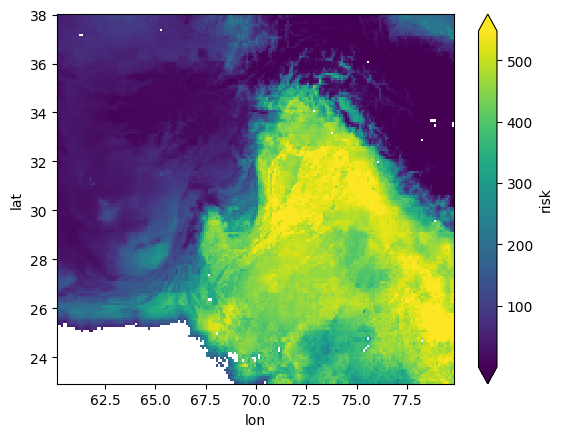

In [49]:
risk.plot(
    x = 'lon',
    y ='lat',
    robust = True
)

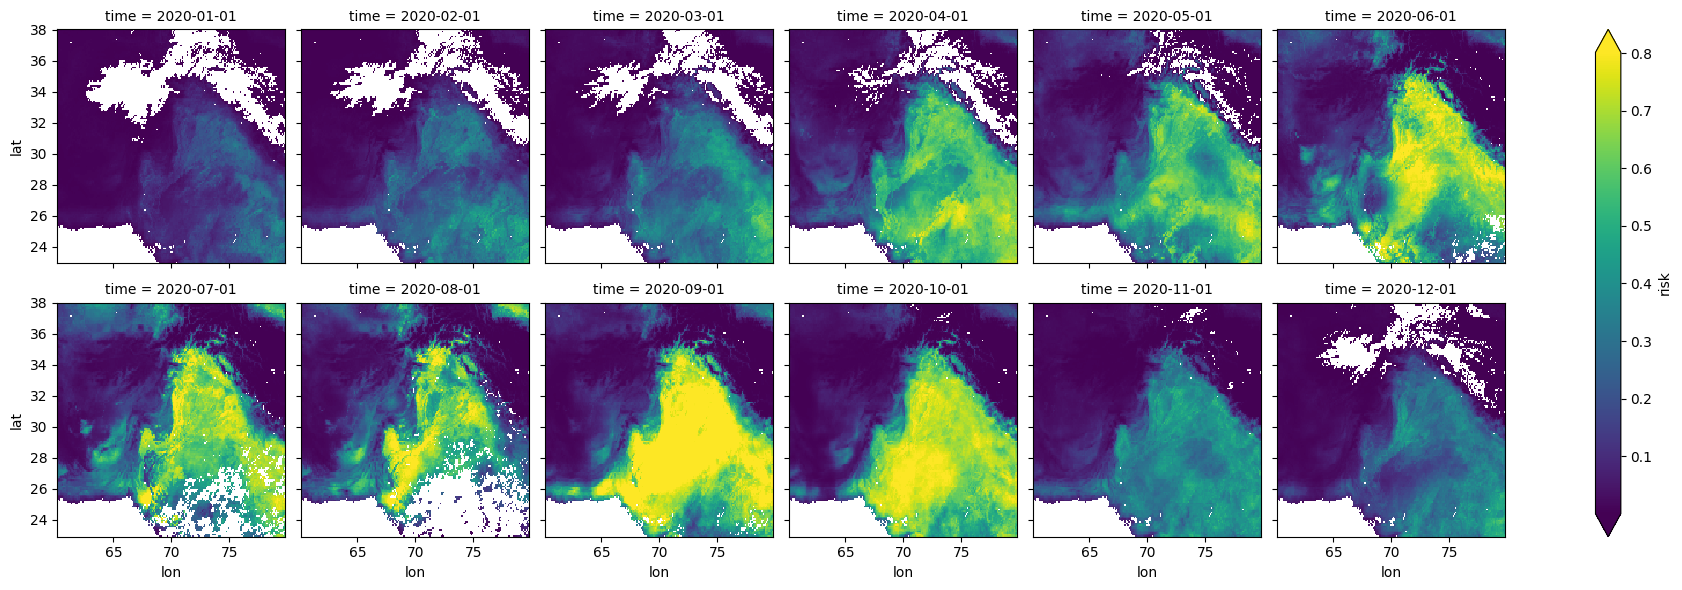

In [50]:
dfx.risk.plot(
    x = 'lon',
    y = 'lat',
    col = 'time',
    col_wrap = 6,
    robust = True
)